数据观察

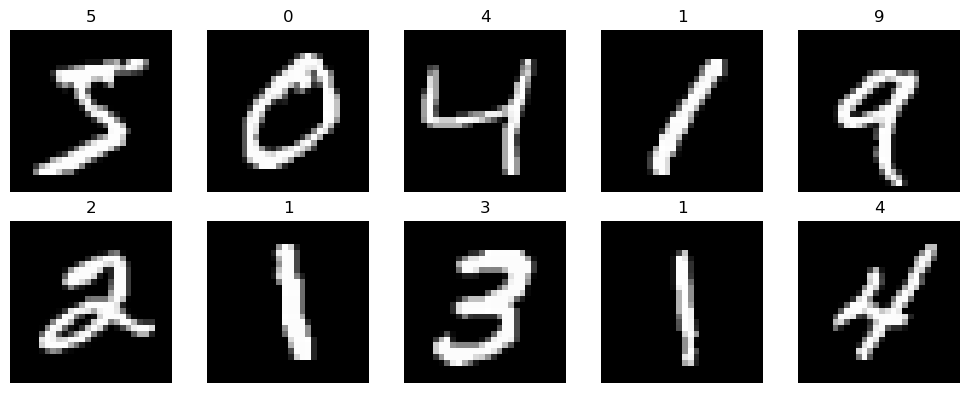

In [2]:
# 数据集\train-images.idx3-ubyte
# 数据集\train-labels.idx1-ubyte

import struct
import numpy as np
import matplotlib.pyplot as plt

# 读取训练集数据
with open('数据集/train-images.idx3-ubyte', 'rb') as f:
    magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
    train_images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)

# 读取训练集标签
with open('数据集/train-labels.idx1-ubyte', 'rb') as f:
    magic, num = struct.unpack('>II', f.read(8))
    train_labels = np.fromfile(f, dtype=np.uint8)

# 显示前10个样本
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(train_labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

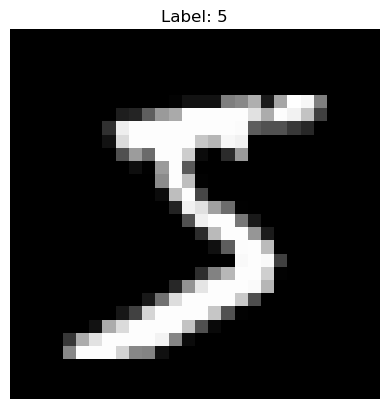

In [3]:
import matplotlib.pyplot as plt

def show_sample(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# 查看第一个训练样本
show_sample(train_images[0], train_labels[0])

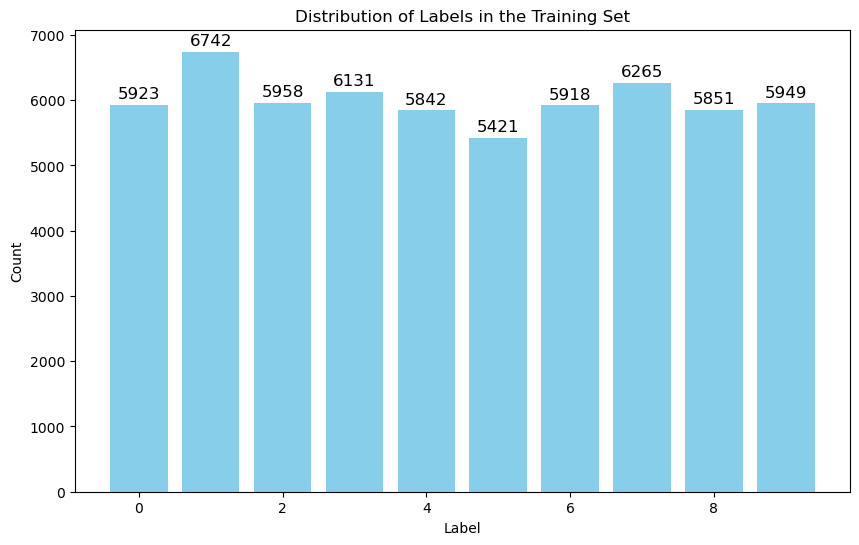

In [7]:
# 统计各个标签数量
label_counts = np.bincount(train_labels)

# 绘制标签分布图（加上具体数字，颜色）

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(10), label_counts,color='skyblue')
for i, v in enumerate(label_counts):
    ax.text(i, v + 100, f'{v}', ha='center', fontsize=12)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels in the Training Set')
plt.show()

传统机器学习方法

In [12]:

    # 示例：后续调用模型预测（可单独使用）
    # loaded_model = load('models/random_forest.pkl')
    # sample_pred = loaded_model.predict(X_test[:5])
    # print("示例预测结果:", sample_pred)

In [14]:
import numpy as np
import struct
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

def read_idx_file(file_path):
    """读取MNIST IDX格式二进制文件"""
    with open(file_path, 'rb') as f:
        # 读取文件头（魔数+维度信息）
        if 'images' in file_path:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            data = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows*cols)
            return data.astype(np.float32) / 255.0  # 归一化到[0,1]
        else:
            magic, num_labels = struct.unpack('>II', f.read(8))
            return np.fromfile(f, dtype=np.uint8)

def train_and_save_models(X_train, y_train, model_dir='saved_models'):
    """训练多种传统模型并保存"""
    os.makedirs(model_dir, exist_ok=True)
    
    models = {
        'logistic_regression': LogisticRegression(max_iter=1000, n_jobs=-1),
        'svm_rbf': SVC(kernel='rbf', gamma='scale'),
        'random_forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
        'knn': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    }
    
    for name, model in models.items():
        print(f'训练 {name} 模型中...')
        model.fit(X_train, y_train)
        joblib.dump(model, os.path.join(model_dir, f'{name}_mnist.pkl'))
    print('所有模型训练并保存完成\n')

def evaluate_and_save(X_test, y_test, model_dir='saved_models', result_path='evaluation_results.csv'):
    """评估模型并保存结果到表格"""
    results = []
    
    for model_file in os.listdir(model_dir):
        if not model_file.endswith('.pkl'):
            continue
            
        model_path = os.path.join(model_dir, model_file)
        model = joblib.load(model_path)
        model_name = model_file.split('_')[0]
        
        # 模型预测
        y_pred = model.predict(X_test)
        
        # 收集评估指标
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # 提取关键指标（宏观平均）
        metrics = {
            '模型名称': model_name,
            '准确率': acc,
            '精确率（宏平均）': report['macro avg']['precision'],
            '召回率（宏平均）': report['macro avg']['recall'],
            'F1值（宏平均）': report['macro avg']['f1-score'],
            '样本量': report['macro avg']['support']
        }
        
        # 收集混淆矩阵对角线（正确分类数）
        cm = confusion_matrix(y_test, y_pred)
        metrics.update({f'类别{i}_正确数': cm[i,i] for i in range(10)})
        
        results.append(metrics)
    
    # 保存为表格
    df = pd.DataFrame(results)
    df.to_csv(result_path, index=False)
    print(f'评估结果已保存至 {result_path}')
    return df

if __name__ == '__main__':
    # 数据路径（根据实际存储位置调整）
    data_paths = {
        'train_images': '数据集/t10k-images.idx3-ubyte',  # 用户指定的训练集图像
        'train_labels': '数据集/t10k-labels.idx1-ubyte',  # 用户指定的训练集标签
        'test_images': '数据集/train-images.idx3-ubyte',   # 用户指定的测试集图像
        'test_labels': '数据集/train-labels.idx1-ubyte'    # 用户指定的测试集标签
    }
    
    # 读取数据（注意用户数据命名可能与常规相反）
    print('读取训练数据...')
    X_train = read_idx_file(data_paths['train_images'])
    y_train = read_idx_file(data_paths['train_labels'])
    
    print('读取测试数据...')
    X_test = read_idx_file(data_paths['test_images'])
    y_test = read_idx_file(data_paths['test_labels'])
    
    # 训练并保存模型
    train_and_save_models(X_train, y_train)
    
    # 评估并保存结果
    evaluate_and_save(X_test, y_test)
    

读取训练数据...
读取测试数据...
训练 logistic_regression 模型中...
训练 svm_rbf 模型中...
训练 random_forest 模型中...
训练 knn 模型中...
所有模型训练并保存完成

评估结果已保存至 evaluation_results.csv


测试

加载模型中...
正在预测图片: 数据集/手写数字图像/1/7.jpg

预测结果：
knn               : 7
logistic          : 7
random            : 7
svm               : 7


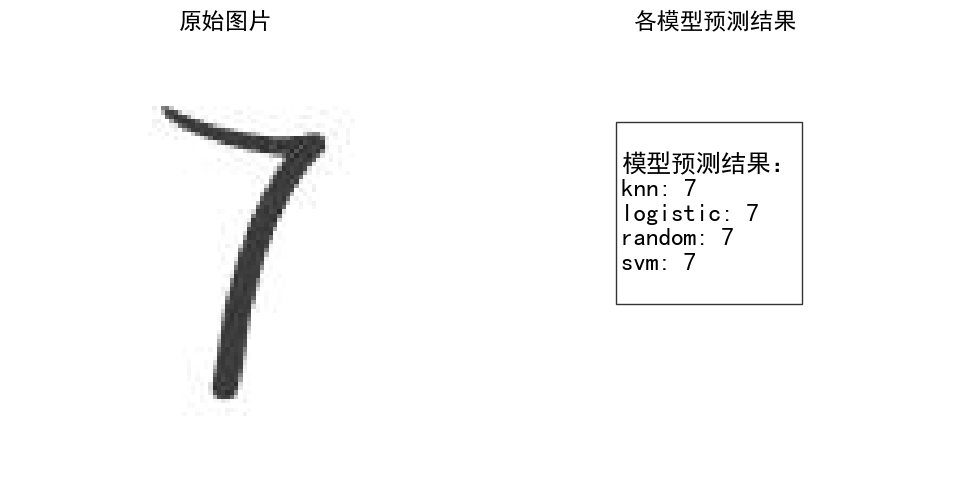

In [32]:
import numpy as np
import joblib
from PIL import Image
import os
import matplotlib.pyplot as plt

# 定义字体
font = {'family': 'SimHei', 'size': 14}  # 设置字体为黑体
plt.rc('font', **font)  # 应用字体设置

def preprocess_image(image_path, target_size=(28, 28)):
    """
    预处理图像以匹配模型输入要求
    参数:
        image_path: 实际图片路径（支持png/jpg等格式）
        target_size: 目标尺寸（MNIST为28x28）
    返回:
        预处理后的一维数组（784个特征）
    """
    # 读取图像并转换为灰度图
    img = Image.open(image_path).convert('L')
    
    # 调整尺寸（保持宽高比，不足部分填充黑色）
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    
    # 转换为numpy数组并归一化（0-255 → 0-1）
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    # MNIST是黑底白字（0背景，255数字），若实际图片是白底黑字需要反转
    # 可根据实际情况注释或取消注释下一行
    img_array = 1.0 - img_array  # 反转颜色（如果输入是白底黑字）
    
    # 展平为一维数组（与训练数据格式一致）
    return img_array.flatten().reshape(1, -1)

def load_models(model_dir='saved_models'):
    """加载所有保存的模型"""
    models = {}
    for model_file in os.listdir(model_dir):
        if model_file.endswith('.pkl'):
            model_name = model_file.split('_')[0]
            models[model_name] = joblib.load(os.path.join(model_dir, model_file))
    return models

def predict_image(image_path, models):
    """
    对单张图片进行多模型预测
    返回: 包含各模型预测结果的字典
    """
    # 预处理图像
    processed_img = preprocess_image(image_path)
    
    # 多模型预测
    predictions = {}
    for model_name, model in models.items():
        pred = model.predict(processed_img)
        predictions[model_name] = pred[0]  # 取出单个预测结果
    return predictions

def visualize_result(image_path, predictions):
    """可视化预测结果"""
    # 读取原始图像用于展示
    img = Image.open(image_path)
    
    # 创建展示窗口
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # 显示原始图像
    ax1.imshow(img)
    ax1.set_title('原始图片')
    ax1.axis('off')
    
    # 显示预测结果
    result_text = "\n模型预测结果：\n"
    for model_name, pred in predictions.items():
        result_text += f"{model_name}: {pred}\n"
    
    
    # 更大
    ax2.text(0.3, 0.4, result_text, fontsize=18,
            bbox=dict(facecolor='white', alpha=0.8))
    ax2.set_title('各模型预测结果')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # 配置参数（根据实际情况修改）
    IMAGE_PATH = '数据集/手写数字图像/1/7.jpg'  # 替换为你的实际图片路径
    MODEL_DIR = 'saved_models'     # 模型保存目录（与训练代码一致）
    
    # 加载所有训练好的模型
    print('加载模型中...')
    models = load_models(MODEL_DIR)
    
    # 对指定图片进行预测
    print(f'正在预测图片: {IMAGE_PATH}')
    predictions = predict_image(IMAGE_PATH, models)
    
    # 打印文本结果
    print('\n预测结果：')
    for model_name, pred in predictions.items():
        print(f'{model_name.ljust(18)}: {pred}')
    
    # 可视化结果（需要图形界面支持）
    visualize_result(IMAGE_PATH, predictions)
    

加载模型中...
正在处理文件夹: 数据集/手写数字图像/3
完成 10 张图片的预测
汇总图已保存至: r3_t.png


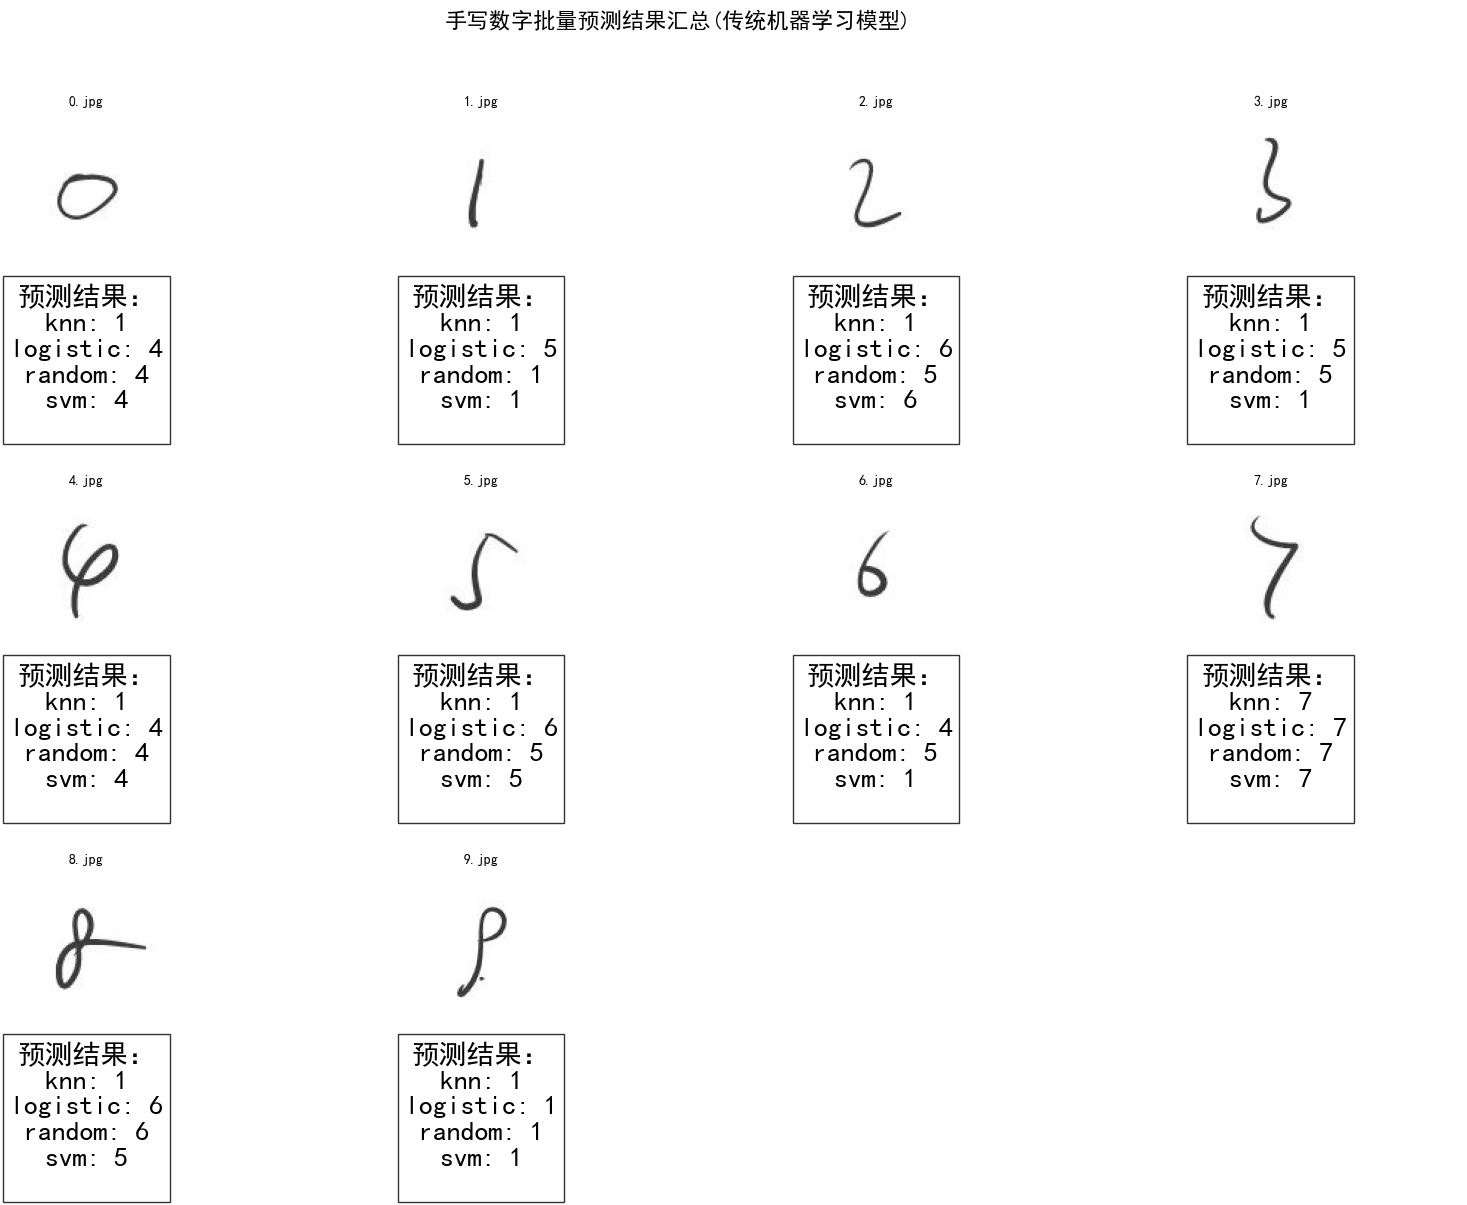

In [46]:
import numpy as np
import joblib
from PIL import Image
import os
import matplotlib.pyplot as plt
from glob import glob

def preprocess_image(image_path, target_size=(28, 28)):
    """图像预处理（与单张预测版本保持一致）"""
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img, dtype=np.float32) / 255.0
    # 若需要颜色反转（白底黑字转黑底白字），取消下一行注释
    img_array = 1.0 - img_array
    return img_array.flatten().reshape(1, -1)

def load_models(model_dir='saved_models'):
    """加载所有保存的模型（与单张预测版本保持一致）"""
    return {
        model_file.split('_')[0]: joblib.load(os.path.join(model_dir, model_file))
        for model_file in os.listdir(model_dir) if model_file.endswith('.pkl')
    }

def predict_image(image_path, models):
    """单张图片预测（返回带图片路径的结果字典）"""
    processed_img = preprocess_image(image_path)
    return {
        'image_path': image_path,
        'predictions': {name: model.predict(processed_img)[0] 
                       for name, model in models.items()}
    }

def batch_predict(image_folder, models):
    """批量预测文件夹中的所有图片"""
    # 获取所有图片路径（支持常见图片格式）
    image_paths = glob(os.path.join(image_folder, '*.png')) + \
                  glob(os.path.join(image_folder, '*.jpg')) + \
                  glob(os.path.join(image_folder, '*.jpeg'))
    
    # 批量预测并收集结果
    results = []
    for img_path in image_paths:
        try:
            results.append(predict_image(img_path, models))
        except Exception as e:
            print(f'警告：处理 {img_path} 时出错: {str(e)}，已跳过')
    return results

def create_summary_plot(results, output_path='prediction_summary.png', cols=4):
    """
    创建批量预测结果汇总图
    参数:
        results: 批量预测结果列表（包含image_path和predictions）
        output_path: 汇总图保存路径
        cols: 每行显示的图片数量（自动计算行数）
    """
    # 计算布局参数
    rows = (len(results) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    fig.suptitle('手写数字批量预测结果汇总(传统机器学习模型)', fontsize=16, y=1.02)

    # 遍历每个结果绘制子图
    for idx, result in enumerate(results):
        row, col = idx // cols, idx % cols
        ax = axes[row, col] if rows > 1 else axes[col] if cols > 1 else axes

        # 显示原始图片
        img = Image.open(result['image_path'])
        ax.imshow(img)
        ax.axis('off')

        # 生成预测结果文本
        pred_text = "预测结果：\n"
        for model_name, pred in result['predictions'].items():
            pred_text += f"{model_name}: {pred}\n"

        # 添加结果标注（半透明背景框）
        ax.text(0.5, -0.15, pred_text, 
                transform=ax.transAxes,
                ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.8, pad=5),
                fontsize=20)

        # 设置子图标题（原始文件名）
        ax.set_title(os.path.basename(result['image_path']), fontsize=10)

    # 隐藏多余的子图（当图片数不是cols整数倍时）
    for idx in range(len(results), rows*cols):
        row, col = idx // cols, idx % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f'汇总图已保存至: {output_path}')

if __name__ == '__main__':
    # 配置参数（根据实际情况修改）
    IMAGE_FOLDER = '数据集/手写数字图像/3'   # 输入图片文件夹路径
    MODEL_DIR = 'saved_models'     # 模型保存目录
    OUTPUT_PATH = 'r3_t.png'  # 汇总图保存路径

    # 加载模型
    print('加载模型中...')
    models = load_models(MODEL_DIR)

    # 批量预测
    print(f'正在处理文件夹: {IMAGE_FOLDER}')
    results = batch_predict(IMAGE_FOLDER, models)
    print(f'完成 {len(results)} 张图片的预测')

    # 生成并保存汇总图
    if results:
        create_summary_plot(results, OUTPUT_PATH)
    else:
        print('警告：未找到可处理的图片文件')
    